# Introduction
- this notebook will cover sentiment analysis of movie reviews using recurrent neural networks using first Skip-grams model to extract words embeddings for the words that appear in the reviews and then using this word embedding as the first layer for the RNN to give a vector representation for each word
- the model will take the whole review as input and decide if it's a positive review or negative review

**Sections**
1. load and view the dataset
2. dataset preprocessing
3. prepare the dataset for training
4. create the RNN model with embedding layer from trained skip-gram model
5. model training
6. evaluation and infrences


In [12]:
import os
import random
import traintracker
import torch
import numpy as np
import pandas as pd
from collections import Counter
import src
skip_gram_weights_pth="../model_weights/skipgram"
raw_dataset_dir = "../dataset/raw"
prep_dataset_dir = "../dataset/preprocessed/sentiment_analysis"
prep_dataset_dir_skipgram = "../dataset/preprocessed/skipgram"

# Load view Dataset
1. load reviews and labels text file , reviews and labels are line separated
2. collect some statistics about reviews lengths to decide a fixed length for a review, words frequency to ignore high frequent words

In [13]:
os.listdir(raw_dataset_dir)

['labels.txt', 'reviews.txt', 'text8']

In [14]:
with open(os.path.join(prep_dataset_dir_skipgram, 'reviews.txt'), 'r') as rev_file:
    raw_reviews_txt = rev_file.read()
with open(os.path.join(raw_dataset_dir, 'labels.txt'), 'r') as labels_file:
    raw_labels_txt = labels_file.read()

In [15]:
raw_reviews_txt[:250]

'bromwell high cartoon comedy ran same other programs school life such teachers years teaching profession lead believe bromwell high satire much closer reality teachers scramble survive financially insightful students right through pathetic teachers p'

In [16]:
# split('\n')[:-1] to ignore the last empty line
reviews_list = raw_reviews_txt.split('\n')
labels_list = raw_labels_txt.split('\n')[:-1]

In [17]:
print(f"no of reviews {len(reviews_list)}")

print(f"no of labels {len(labels_list)}")

no of reviews 25000
no of labels 25000


-

In [18]:
reviews_count_list = []
words_counter = Counter(raw_reviews_txt.split())

for review in reviews_list:
    reviews_count_list.append([len(review)])

reviews_cnt_df = pd.DataFrame(reviews_count_list, columns=['review length']).sort_values(ascending=False,
                                                                                         by=['review length'])
words_cnt_df = pd.DataFrame(words_counter.items(), columns=['word', 'word count']).sort_values(ascending=False,
                                                                                               by=['word count'])

## reviews lengths

In [19]:
reviews_cnt_df.head(50)

,review length
3908,9709
98,6475
12516,6454
11834,5897
7067,5877
7063,5762
8692,5666
11882,5180
9401,5046
3008,5040


In [20]:
reviews_cnt_df.tail(50)

,review length
12355,92
2410,92
21934,91
14196,91
21842,90
11103,89
6115,89
12272,88
5509,88
4784,88


In [21]:
reviews_cnt_df.describe()

,review length
count,25000.000000
mean,834.313480
std,657.140607
min,17.000000
25%,426.000000
50%,609.000000
75%,1018.000000
max,9709.000000


In [22]:
reviews_cnt_df.median()

review length    609.0
dtype: float64

<AxesSubplot:>

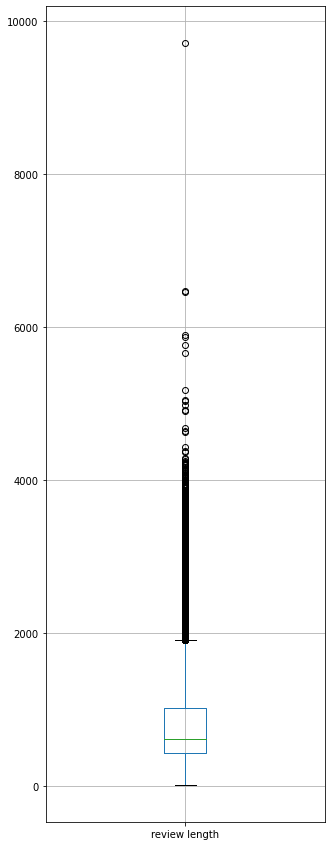

In [93]:
reviews_cnt_df.boxplot(figsize=(5, 15))

array([[<AxesSubplot:title={'center':'review length'}>]], dtype=object)

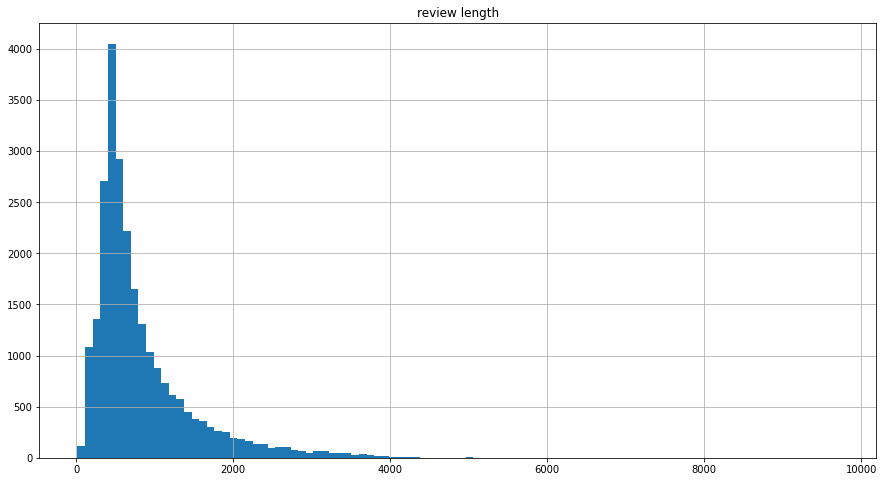

In [94]:
reviews_cnt_df.hist(bins=100, figsize=(15, 8))

In [95]:
reviews_cnt_df[100:-100].describe()

,review length
count,24800.000000
mean,823.590887
std,619.388063
min,109.000000
25%,428.000000
50%,609.000000
75%,1013.000000
max,3751.000000


array([[<AxesSubplot:title={'center':'review length'}>]], dtype=object)

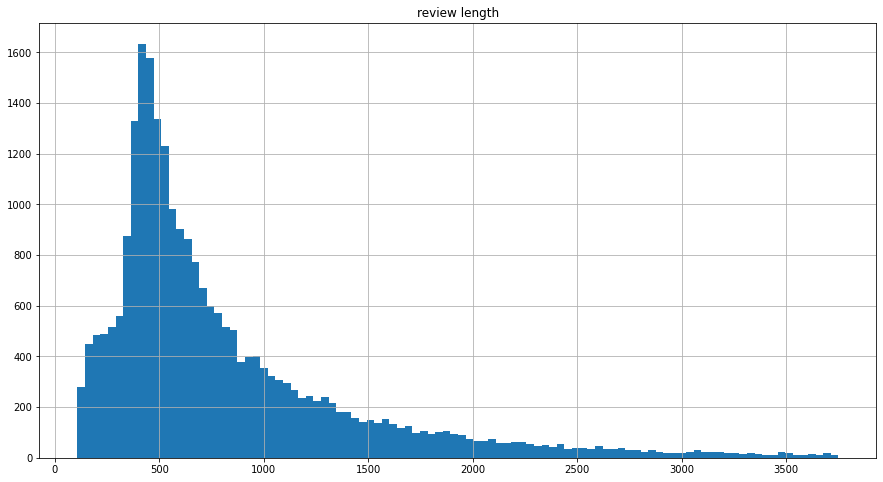

In [96]:
reviews_cnt_df[100:-100].hist(bins=100, figsize=(15, 8))

- Conclusion
    - most of the reviews are around 1000 word after ignoring 100 from the left and right

In [23]:
words_cnt_df.head(50)

,word,word count
18,much,9763
975,get,9309
433,bad,9308
122,been,9289
138,people,9285
279,will,9211
190,do,9177
6,other,9163
304,also,9158
76,into,9111


In [99]:
words_cnt_df.tail(50)

,word,word count
39165,beasley,2
39166,spenser,2
39167,tirelli,2
39168,effing,2
29254,dogmas,2
39170,vacancy,2
39171,wanderers,2
39172,perspicacious,2
29252,partway,2
39174,onlooker,2


In [100]:
words_cnt_df.describe()

,word count
count,46343.000000
mean,66.102626
std,368.406740
min,2.000000
25%,3.000000
50%,7.000000
75%,24.000000
max,9763.000000


<AxesSubplot:>

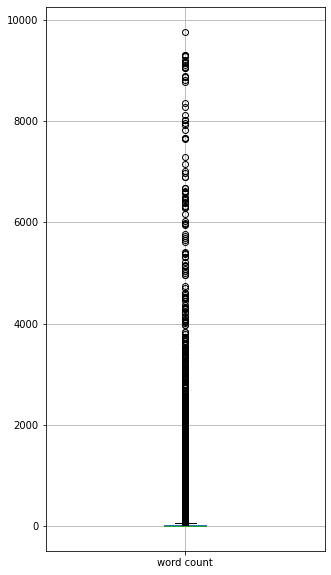

In [101]:
words_cnt_df.boxplot(figsize=(5, 10))

# Data preprocessing
- remove words that appear both in negative reviews and positive reviews and doesn't have weight in deciding whether this review is positive or negative. words like `the,is,a,do,..etc`
- remove words that don't appear much may be misspelling

In [2]:
with open(os.path.join(prep_dataset_dir_skipgram, 'reviews.txt'), 'r') as rev_file:
    raw_reviews_txt = rev_file.read()
with open(os.path.join(raw_dataset_dir, 'labels.txt'), 'r') as labels_file:
    raw_labels_txt = labels_file.read()

- we have now the count of each word in both positive and negative, but we want the words that appear in positive only and doesn't appear in negative and vice versa
- ![word_importance.png](assets/word_importance.png)


- away for this to calculate the ration of the word log(positive_cnt/negative_cnt)
- if count of the word in positive reviews nearly equal in negative reviews
    - the result will be near to zero
- if it appears in positive
    - the result will be large number greater than 0  +ve
- if it appears more in negative
    - the result will be large negative number -ve

In [7]:
prep_reviews, words_pos_neg_ratio, removed_words = src.remove_common_words(raw_reviews_txt, labels=raw_labels_txt,
                                                                           threshold=0.1, min_freq=2)
min_val,max_val=0,-1

for word,ratio in words_pos_neg_ratio.items():
    min_val=min(ratio,min_val)
    max_val=max(ratio,max_val)
print(f"min_val {min_val}")
print(f"max_val {max_val}")

min_val -4.276666119016055
max_val 4.700480365792417


In [ ]:
w_pos_neg_ratio_df = pd.DataFrame(words_pos_neg_ratio.items(), columns=['word', 'ratio'])

In [ ]:
w_pos_neg_ratio_df[(w_pos_neg_ratio_df.ratio <= 0.7) & (w_pos_neg_ratio_df.ratio > 0)]

In [ ]:
print("common words")
print(f"pos and negative ratio for 'the' {words_pos_neg_ratio['those']}")
print(f"pos and negative ratio for 'is' {words_pos_neg_ratio['him']}")
print(f"pos and negative ratio for 'is' {words_pos_neg_ratio['']}")
print("\nPostive words")

print(f"pos and negative ratio for 'wonderful' {words_pos_neg_ratio['wonderful']}")
print(f"pos and negative ratio for 'amazing' {words_pos_neg_ratio['amazing']}")

print("\nnegative words")
print(f"pos and negative ratio for 'bad' {words_pos_neg_ratio['bad']}")
print(f"pos and negative ratio for 'worse' {words_pos_neg_ratio['worse']}")

In [2]:
len(removed_words)

NameError: name 'removed_words' is not defined

In [105]:
start = random.randint(0, len(removed_words) - 100)
end = start + 100
removed_words[start:end]

['estimate',
 'scrotum',
 'deranged',
 'foresee',
 'hebetude',
 'liners',
 'becker',
 'marton',
 'bolder',
 'haysbert',
 'capra',
 'fried',
 'concepts',
 'swiss',
 'medals',
 'korean',
 'thousands',
 'anally',
 'rothrock',
 'sliding',
 'branding',
 'armani',
 'processed',
 'immediately',
 'besson',
 'barmans',
 'parallax',
 'pummeled',
 'cats',
 'revival',
 'accusing',
 'menu',
 'chauvinist',
 'vieira',
 'massacre',
 'nocturnal',
 'deforrest',
 'myers',
 'sword',
 'mais',
 'snorting',
 'sudden',
 'exploring',
 'retractable',
 'gravitational',
 'theses',
 'amusement',
 'zimbabwe',
 'nymphomaniac',
 'fur',
 'doughnut',
 'stationed',
 'langoliers',
 'insurmountable',
 'commander',
 'undertakings',
 'holders',
 'worn',
 'begotten',
 'wholly',
 'melange',
 'shaye',
 'adding',
 'utilizing',
 'climaxed',
 'chim',
 'wrung',
 'toothed',
 'slaughter',
 'fancies',
 'evolvement',
 'anorak',
 'cancel',
 'congratulate',
 'parekh',
 'luring',
 'legislature',
 'mailed',
 'johns',
 'virginity',
 'hough

In [72]:
# split('\n')[:-1] to ignore the last empty line
reviews_list = prep_reviews.split('\n')[:-1]
labels_list = prep_reviews.split('\n')[:-1]

reviews_count_list = []
words_counter = Counter(prep_reviews.split())

for review in reviews_list:
    reviews_count_list.append([len(review)])

reviews_cnt_df = pd.DataFrame(reviews_count_list, columns=['review length']).sort_values(ascending=False,
                                                                                         by=['review length'])
words_cnt_df = pd.DataFrame(words_counter.items(), columns=['word', 'word count']).sort_values(ascending=False,
                                                                                               by=['word count'])

array([[<AxesSubplot:title={'center':'review length'}>]], dtype=object)

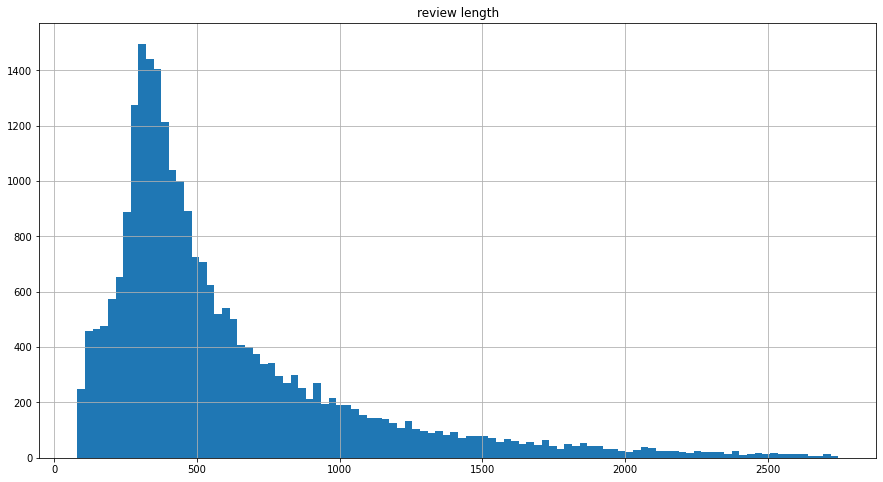

In [73]:
reviews_cnt_df[100:-100].hist(bins=100, figsize=(15, 8))

In [74]:
reviews_cnt_df.describe()

,review length
count,25000.000000
mean,610.741960
std,476.949979
min,19.000000
25%,314.000000
50%,448.000000
75%,746.000000
max,6583.000000


- mean of no of words in a review about 800 word per review after removing noisy words

In [75]:
words_cnt_df.head(100)

,word,word count
1,as,46933
385,movie,44039
33,t,34081
121,his,29374
94,they,22906
...,...,...
65,might,2918
648,performance,2896
1067,kind,2783
948,yet,2752


In [76]:
words_cnt_df.describe()

,word count
count,37023.000000
mean,63.137428
std,601.067486
min,2.000000
25%,3.000000
50%,7.000000
75%,22.000000
max,46933.000000


<AxesSubplot:>

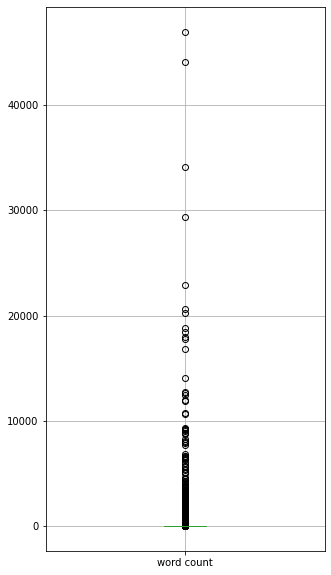

In [77]:
words_cnt_df.boxplot(figsize=(5, 10))

# Train Data Loader

In [3]:
import json
with open(os.path.join(prep_dataset_dir,"word2int.json"), "r") as word2int_file:
    word2int=json.load( word2int_file)


In [4]:
sentiment_dataloader=src.SentimentAnalysisDataset(raw_reviews_txt,labels_txt=raw_labels_txt,word2int=word2int,batch_size=64,def_review_len=800)

In [5]:
test_iter=iter(sentiment_dataloader)
x,y=next(test_iter)

# Sentiment analysis model
- TODO describe the model and the forward function

In [6]:
skip_gram_model=src.SkipGram(vocab_size=len(word2int),embedding_size=512)
state_dict=torch.load(traintracker.latest_weights_path(skip_gram_weights_pth),map_location="cpu")
skip_gram_model.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
sentiment_model=src.SentimentAnalysis(word2int=word2int,embedding_dim=512,n_layers=2,hidden_nodes=256,embedding_layer=skip_gram_model.input_embedding)